# **Fake News Detection**

###Alfano Caterina - Berardi Angelo - Cappelli Dario - Fratocchi Emanuele 

# Installs & Imports

In [ ]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 9.4MB/s 
     |████████████████████████████████| 3.7MB 10.1MB/s 
     |████████████████████████████████| 133kB 45.0MB/s 
     |████████████████████████████████| 890kB 46.2MB/s 
     |████████████████████████████████| 1.1MB 48.7MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 7.2MB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=cd98ebef8be93d19ca13fce03e8667018dc1d4e918e8354c324a7e364e62b187
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.47 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import  roc_curve, auc
from transformers import BertModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch.nn as nn
import pandas as pd
import transformers
import numpy as np
import warnings
import torch
import re

In [ ]:
device = torch.device("cuda")
print(f'There are {torch.cuda.device_count()} GPU(s) available.')
print('Device name:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Training Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv' , encoding='utf8') #encoding='ISO-8859-1')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
print(df.shape)
print(df.isnull().sum())

(20800, 5)
id           0
title      558
author    1957
text        39
label        0
dtype: int64



# Inspecting Data


In [ ]:
df_news = df[~df['text'].isna()][['text','label']] ## remove where we don't have text
df_news.drop_duplicates(subset=['text'],keep='first',inplace=True) ## remove duplicates

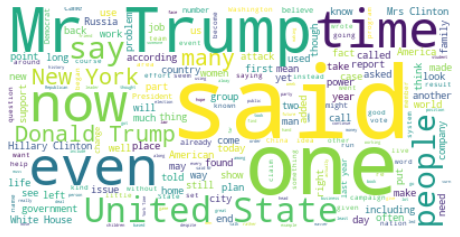

In [ ]:
text = " ".join([x for x in df_news.text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

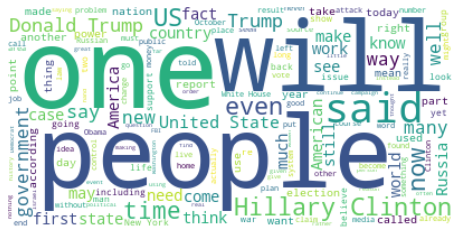

In [ ]:
## for fake

text = " ".join([x for x in df_news.text[df_news.label==1]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

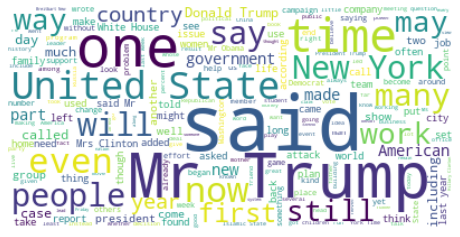

In [ ]:
## for real

text = " ".join([x for x in df_news.text[df_news.label==0]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print('Number of 0 (Not Fake) : ', df_news["label"].value_counts()[0])
print('Number of 1 (Fake) : ', df_news["label"].value_counts()[1])

Number of 0 (Not Fake) :  10387
Number of 1 (Fake) :  9999


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Count')

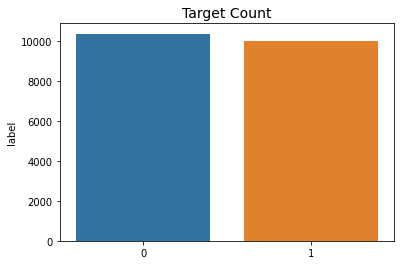

In [ ]:
label = df_news["label"].value_counts()
sns.barplot(label.index, label)
plt.title('Target Count', fontsize=14)

# Preprocessing

In [ ]:
df2 = df.copy()
df2 = df2[df2['text'].notna()]
df2.drop(["author"], axis=1, inplace=True)
df2.drop(["title"], axis=1, inplace=True)
df2.head()

,id,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,Ever get the feeling your life circles the rou...,0
2,2,"Why the Truth Might Get You Fired October 29, ...",1
3,3,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# Splitting the data in train (90%) and validation set (10%)
train_text, val_text, train_labels, val_labels = train_test_split(df2.text.values, df2.label.values, test_size=0.1, random_state=1708581)

In [ ]:
len(train_text), len(val_text)

(18684, 2077)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 3000.0)

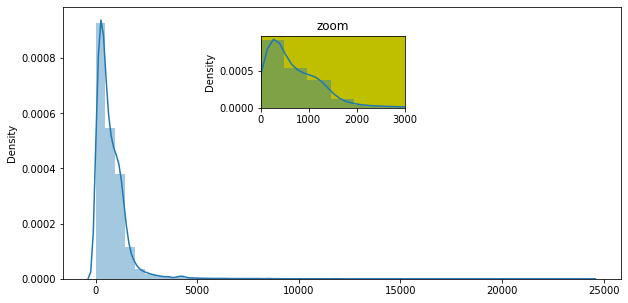

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

fig,ax = plt.subplots(figsize=(10,5))
sns.distplot(pd.Series(seq_len), ax=ax)
ax2 = plt.axes([0.4, 0.6, .2, .2], facecolor='y')
sns.distplot(pd.Series(seq_len), ax=ax2)
ax2.set_title('zoom')
ax2.set_xlim([0, 3000])

# Tokenizer and Data Loader

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
#configuration
MAX_LEN=500
batch_size = 12

In [ ]:
def tokeniz_batc(train, max_len, batch_size):

    print('Tokenizing {:,} training samples...'.format(len(train)))

    batches_input_ids = []
    batches_attention_masks = []

    for s in train: 
        
        encoded_dict = tokenizer.encode_plus(
                            text = s,                        # Batch of sentences to encode.
                            add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                            max_length = max_len,            # Pad & truncate all sentences.
                            pad_to_max_length=True,          # Pad all to the `max_length` parameter.
                            truncation = True,
                            return_attention_mask = True)   # Construct attn. masks.
                    
        
        batches_input_ids.append(encoded_dict['input_ids'])
        batches_attention_masks.append(encoded_dict['attention_mask'])
  
    return batches_input_ids, batches_attention_masks

In [ ]:
py_inputs, py_attn_masks  = tokeniz_batc(train_text, MAX_LEN, batch_size)

Tokenizing 18,684 training samples...


In [ ]:
val_inputs, val_attn_masks  = tokeniz_batc(val_text, MAX_LEN, batch_size)

Tokenizing 2,077 training samples...


In [ ]:
# Create the DataLoader for our training set
train_data = TensorDataset(torch.LongTensor(py_inputs), torch.LongTensor(py_attn_masks), torch.tensor(train_labels, dtype=torch.float))

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(torch.LongTensor(val_inputs), torch.LongTensor(val_attn_masks), torch.tensor(val_labels, dtype=torch.float))

val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Bert Fine Tuning


In [ ]:
class BertTuned(nn.Module):

    def __init__(self):
        super(BertTuned, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.bert_drop = nn.Dropout(0.35)
        self.fc = nn.Linear(768, 1)

    def forward(self, ids, mask):
        _, out1 = self.bert(ids, attention_mask=mask)
        out1 = self.bert_drop(out1)
        output = self.fc(out1)
        return output

In [ ]:
model=BertTuned()
model.to(device)

print("Training on ",device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad),' trainable prams')


Training on  cuda
109483009  trainable prams


In [ ]:
# TRAINING SETTINGS
epochs = 1
criterion=nn.BCEWithLogitsLoss()
num_train_steps=int(len(train_text)/batch_size*epochs)
optimizer=transformers.AdamW(model.parameters(), lr=2e-5)
scheduler=transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=num_train_steps)

def train(model, dataloader, optimizer, scheduler, device):
    
    model.train()
    losses = []
    print("Start training!")
    for step, batch in enumerate(dataloader):

        ids, mask, targets = tuple(t.to(device) for t in batch)
        
        optimizer.zero_grad()
        preds=model(ids, mask).squeeze(1)
        
        loss=criterion(preds, targets)
        losses.append(loss.item())
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        if (step % 50 == 0 and step != 0) or (step == len(dataloader) - 1):
                print("Iteration:", step, "over:", len(dataloader)-1)
                
    return losses

        
def evaluation(model, dataloader, device):
    
    model.eval()
    fin_targets, fin_outputs=[], []
    print("Starting evaluation!")

    with torch.no_grad():
        for step, batch in enumerate(dataloader):

            ids, mask, targets = tuple(t.to(device) for t in batch)
            preds=model(ids, mask)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.round(torch.sigmoid(preds)).cpu().detach().numpy().tolist())

        accuracy=accuracy_score(fin_targets, fin_outputs)

        if (step % 50 == 0 and step != 0) or (step == len(dataloader) - 1):
          print("Iteration:", step, "over:", len(dataloader)-1 )
            
        return accuracy

In [ ]:
best_accuracy=0
model_path='drive/MyDrive/modelF5.pt'

track_loss = []
for epoch in range(epochs):

    l = train(model, train_dataloader, optimizer, scheduler, device)
    track_loss += l

    accuracy = evaluation(model, val_dataloader, device)

    print("Epoch:", epoch+1," Accuracy: ",accuracy)

    if accuracy > best_accuracy:
        torch.save(model.state_dict(),model_path)
        best_accuracy=accuracy

Start training!
Iteration: 50 over: 1556
Iteration: 100 over: 1556
Iteration: 150 over: 1556
Iteration: 200 over: 1556
Iteration: 250 over: 1556
Iteration: 300 over: 1556
Iteration: 350 over: 1556
Iteration: 400 over: 1556
Iteration: 450 over: 1556
Iteration: 500 over: 1556
Iteration: 550 over: 1556
Iteration: 600 over: 1556
Iteration: 650 over: 1556
Iteration: 700 over: 1556
Iteration: 750 over: 1556
Iteration: 800 over: 1556
Iteration: 850 over: 1556
Iteration: 900 over: 1556
Iteration: 950 over: 1556
Iteration: 1000 over: 1556
Iteration: 1050 over: 1556
Iteration: 1100 over: 1556
Iteration: 1150 over: 1556
Iteration: 1200 over: 1556
Iteration: 1250 over: 1556
Iteration: 1300 over: 1556
Iteration: 1350 over: 1556
Iteration: 1400 over: 1556
Iteration: 1450 over: 1556
Iteration: 1500 over: 1556
Iteration: 1550 over: 1556
Iteration: 1556 over: 1556
Starting evaluation!
Iteration: 173 over: 173
Epoch: 1  Accuracy:  0.9971112181030333


In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/NewModel2.pt")

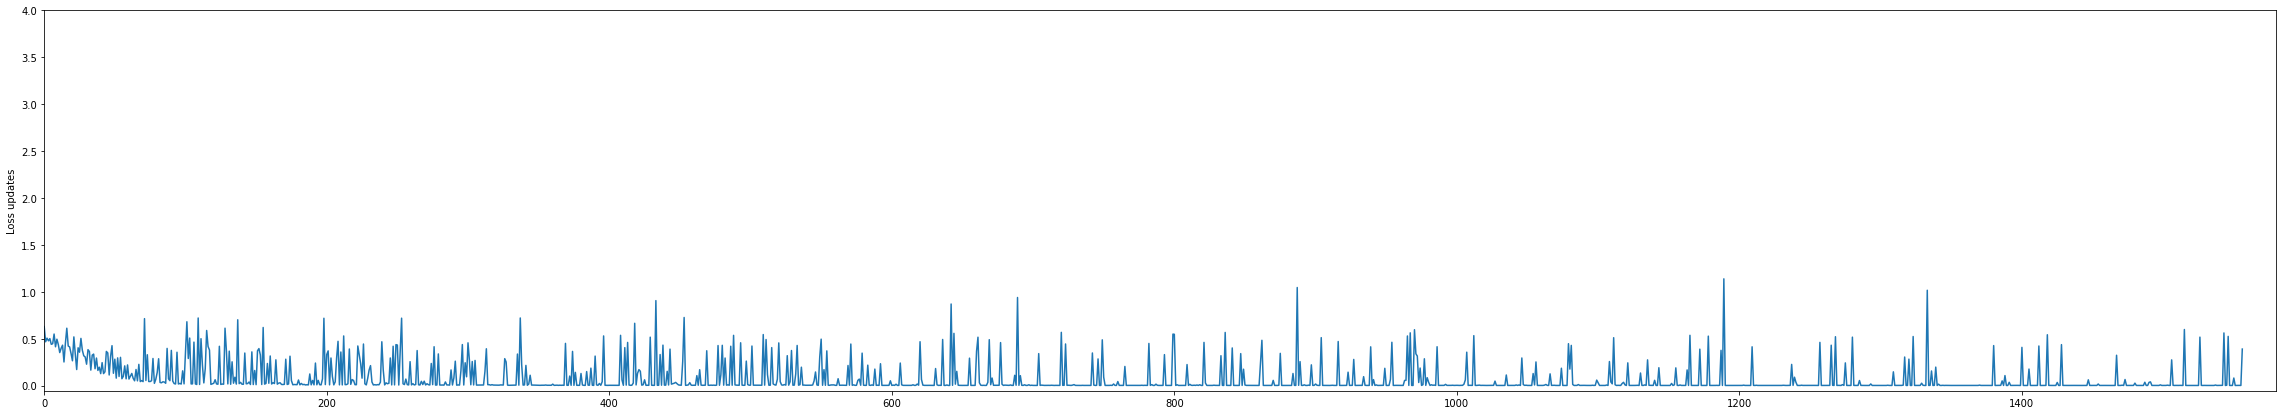

In [ ]:
#Plotting Losses
plt.figure(figsize=(40,7))
plt.plot(track_loss)
plt.ylim(top=4)
plt.xlim(left=0, right=1580) 
plt.ylabel('Loss updates')
plt.show()

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#If we want to upload an already trained model
model = BertTuned()
model.load_state_dict(torch.load('drive/MyDrive/modelF3.pt'))
model.to(device)

# Predicting on test data

#### Preparing data

In [ ]:
df_test =pd.read_csv('drive/MyDrive/test.csv' , encoding='utf8') 
df_test.drop(["author"], axis=1, inplace=True)
df_test.drop(["title"], axis=1, inplace=True)
df_test.head()

,id,text
0,20800,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...
2,20802,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"If at first you don’t succeed, try a different..."
4,20804,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
print(df_test.isnull().sum())
print(df_test.shape)

id         0
title    122
text       7
dtype: int64
(5200, 3)


In [ ]:
df_test = df_test.fillna(' ')

In [ ]:
test = df_test["text"].tolist()

In [ ]:
py_inputs_test, py_attn_masks_test  = tokeniz_batc(test, MAX_LEN, batch_size)

Tokenizing 5,200 training samples...


In [ ]:
test_data = TensorDataset(torch.LongTensor(py_inputs_test), torch.LongTensor(py_attn_masks_test) )
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
len(test_dataloader)

434

#### Making Predictions

In [ ]:
def predict(model, data, device):
    
    model.eval()
    outputs=[]

    for step,batch in enumerate(data):
      ids, mask = tuple(t.to(device) for t in batch)[:2]
      with torch.no_grad():
          preds = model(ids, mask)
        
      outputs += torch.round(torch.sigmoid(preds).flatten()).cpu().detach().numpy().tolist()
      if (step % 50 == 0 and step != 0) or (step == len(data) - 1):
        print("Iteration:", step, "over:", len(data) -1)
            
    return outputs

In [ ]:
predicted=predict(model, test_dataloader, device)

Iteration: 50 over: 433
Iteration: 100 over: 433
Iteration: 150 over: 433
Iteration: 200 over: 433
Iteration: 250 over: 433
Iteration: 300 over: 433
Iteration: 350 over: 433
Iteration: 400 over: 433
Iteration: 433 over: 433


In [ ]:
#Putting the predicted labels in the correct format
for i in range(len(predicted)):
    predicted[i]=int(predicted[i])

In [ ]:
#Inspecting our result
predicted[:10]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1]

In [ ]:
to_submit = pd.DataFrame({'label':predicted,'id':df_test.id.values})
to_submit.to_csv('submission.csv', index=False)

In [ ]:
to_submit.head()

,label,id
0,0,20800
1,1,20801
2,1,20802
3,0,20803
4,1,20804


# Classification report on validation set

In [ ]:
p = predict(model, val_dataloader, device)
for i in range(len(p)):
    p[i]=int(p[i])

Iteration: 50 over: 173
Iteration: 100 over: 173
Iteration: 150 over: 173
Iteration: 173 over: 173


In [ ]:
print(classification_report(val_labels, p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1060
           1       1.00      1.00      1.00      1017

    accuracy                           1.00      2077
   macro avg       1.00      1.00      1.00      2077
weighted avg       1.00      1.00      1.00      2077

